## 20250206
Reconsruct 3D images of 100nm polystyrene

In [1]:
import cupy as cp
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import rescale
import os
import matplotlib.pyplot as plt
from scipy.io  import loadmat
from astropy.io import fits
from cupyx.scipy.ndimage import affine_transform
import tifffile

In [16]:
def get_3Dtransform_matrix(theta, pixelsize, mag, fps, v, F_indexmismatch, polarity):
    scale_y = F_indexmismatch * np.cos(theta)
    scale_z = v / fps / (pixelsize / mag)

    if polarity == 1:
        theta = -theta

    M_zxscale = cp.array([[1, 0, 0, 0],
                          [0, 1, 0, 0],
                          [0, 0, scale_z, 0],
                          [0, 0, 0, 1]])

    M_yxscale = cp.array([[1, 0, 0, 0],
                          [0, scale_y, 0, 0],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])

    M_yzshear = cp.array([[1, 0, 0, 0],
                          [0, 1, np.tan(theta), 0],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])

    T = cp.dot(cp.dot(M_zxscale, M_yxscale), M_yzshear)
    return T

def apply_affine_transform_3d(img, transform_matrix, output_shape=None):
    inverse_matrix = cp.linalg.inv(transform_matrix)

    if output_shape is None:
        output_shape = img.shape

    transformed_img = affine_transform(
    img, 
    inverse_matrix[:3, :3], 
    offset=-inverse_matrix[:3, 3], 
    order=1,  # 補間方法（1は線形補間）
    mode='constant',  # 画像の外側の値
    cval=0,  # 定数モードの場合の外側の値,
    output_shape=output_shape
)

    return transformed_img

def get_corr_matrix(x,y,wavelength="405"):
    corr_matrix=np.zeros((x,y))
    for i in range(y):
        corr_matrix[:,i]=(loadmat("../data_calib/ex_corr.mat")[f"ex_corr{wavelength}"].T*loadmat("../data_calib/ex_profile.mat")[f"ex_profile{wavelength}"].T).flatten()
    return corr_matrix/np.mean(corr_matrix)
    

def image_3d_reconstraction(img_stack,img_bg,corr_matrix,transform_matrix):
    img_stack = cp.flip(img_stack, axis=1)
    # for i in range(img_stack.shape[2]):
    #     img_stack[:,:,i]=(img_stack[:,:,i]-img_stack[:,:,i].min()-img_bg)/(corr_matrix)
    del img_bg
    output_shape =  [ int(img_stack.shape[i]*transform_matrix[i,i]) for i in range(3)] # affine変換後のサイズ計算
    transformed_img = apply_affine_transform_3d(img_stack, transform_matrix.T,tuple(output_shape))
    return transformed_img

In [17]:
def compute_shift_3d_gpu(volume1, volume2):
    # Move data to GPU
    volume1_gpu = cp.array(volume1)
    volume2_gpu = cp.array(volume2)
    
    # Compute the Fourier Transforms of both volumes on GPU
    f1 = cp.fft.fftn(volume1_gpu)
    f2 = cp.fft.fftn(volume2_gpu)
    
    # Compute the cross spectrum on GPU
    cross_spectrum = f1 * cp.conj(f2)
    
    # Compute the inverse Fourier Transform of the cross spectrum on GPU
    correlation = cp.fft.ifftn(cross_spectrum)
    
    # Find the position of maximum correlation
    shift_z, shift_y, shift_x = cp.unravel_index(cp.argmax(cp.abs(correlation)), correlation.shape)
    
    # Adjust shift values to be relative to the center of the volumes
    if shift_z > volume1.shape[0] // 2:
        shift_z -= volume1.shape[0]
    if shift_y > volume1.shape[1] // 2:
        shift_y -= volume1.shape[1]
    if shift_x > volume1.shape[2] // 2:
        shift_x -= volume1.shape[2]
    
    return int(shift_x.get()), int(shift_y.get()), int(shift_z.get())

## Path

In [18]:
FILE_PATH = '../data/'
FILE = 'id834_100nm-polystyrene_488.fits'
RESULT_PATH = '../result/'

## Reconstruction

In [19]:
theta = np.arcsin(np.sin(0.62)/1.33) #angle of the light sheet (radian)
pixelsize = 6.5 #pixel size of the image sensor (um)
mag = 200/9 #magnification of the imaging system
fps = 100 #camera frame rate (Hz)
v = 10 #scanning speed of the translational sample stage (um/s)
F_indexmismatch = 1.412; #coefficient that corrects for the depth deformation due to refractive-index mismatach between the primary and secondary objectives
coeff405 = 0.994 #coefficient that corrects for refractive-index dispersion between 405 and 488 channels
coeff637 = 1.0035 #coefficient that corrects for refractive-index dispersion between 637 and 488 channels
shift_405 = (-11, 4, 2)
shift_637 = (-4, 18, -12)

In [20]:
tform488 = get_3Dtransform_matrix(theta,pixelsize,mag, fps, v, F_indexmismatch, 0);

In [21]:
#488
img_bg = cp.array(imread(FILE_PATH+'background_488.tif').T/1.0)
lf=cp.array(imread(FILE_PATH+'profile_488.tif').T/1.0)
lf=lf/cp.mean(lf)
img_stack = cp.array(fits.getdata(FILE_PATH+FILE).T)
img_f=image_3d_reconstraction(img_stack, img_bg, lf, tform488)
np.save(RESULT_PATH+FILE.split('.')[0]+'.npy', img_f)
shape_488 = img_f.shape
del img_stack,img_f

In [22]:
print(shape_488)

(2560, 381, 341)


In [23]:
img_488 = cp.load(RESULT_PATH+FILE.split('.')[0]+'.npy')

In [24]:
img_488.get().max(axis=2).max()

21664

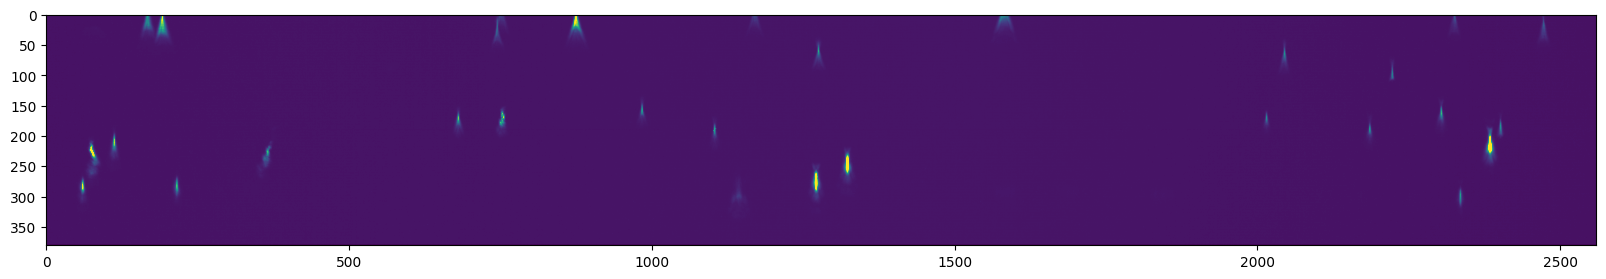

In [25]:
plt.figure(figsize=(20, 20))
plt.imshow(img_488.get().max(axis=2).T, vmax=3000)

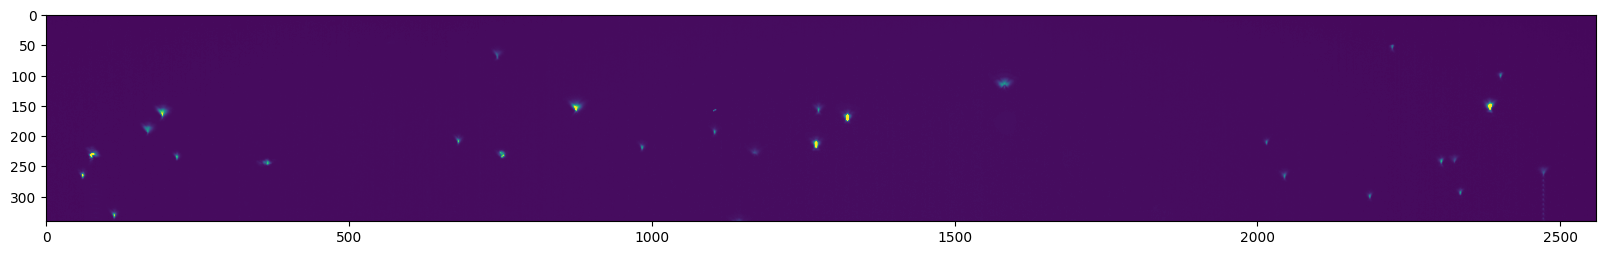

In [26]:
plt.figure(figsize=(20, 20))
plt.imshow(img_488.get().max(axis=1).T, vmax=3000)

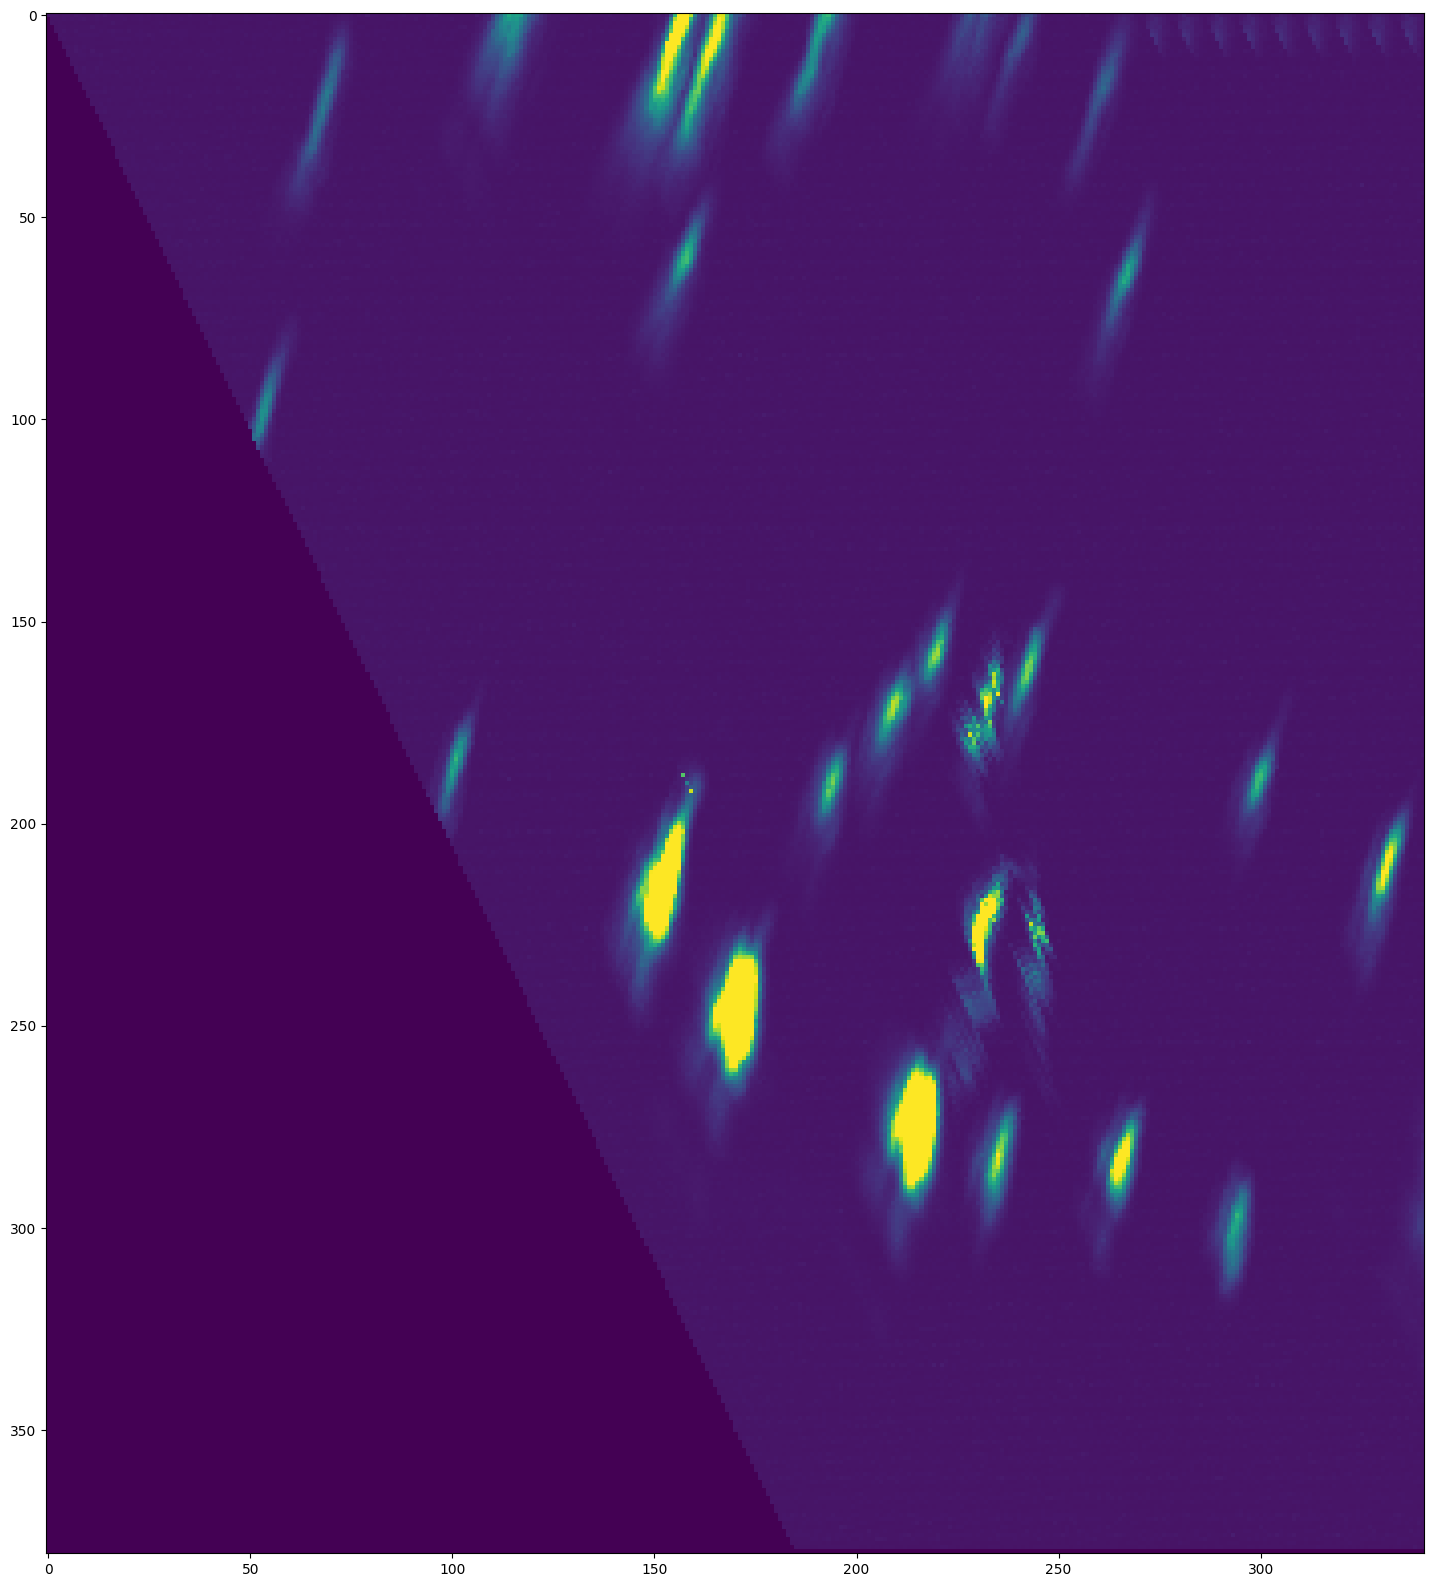

In [27]:
plt.figure(figsize=(20, 20))
plt.imshow(img_488.get().max(axis=0), vmax=3000)

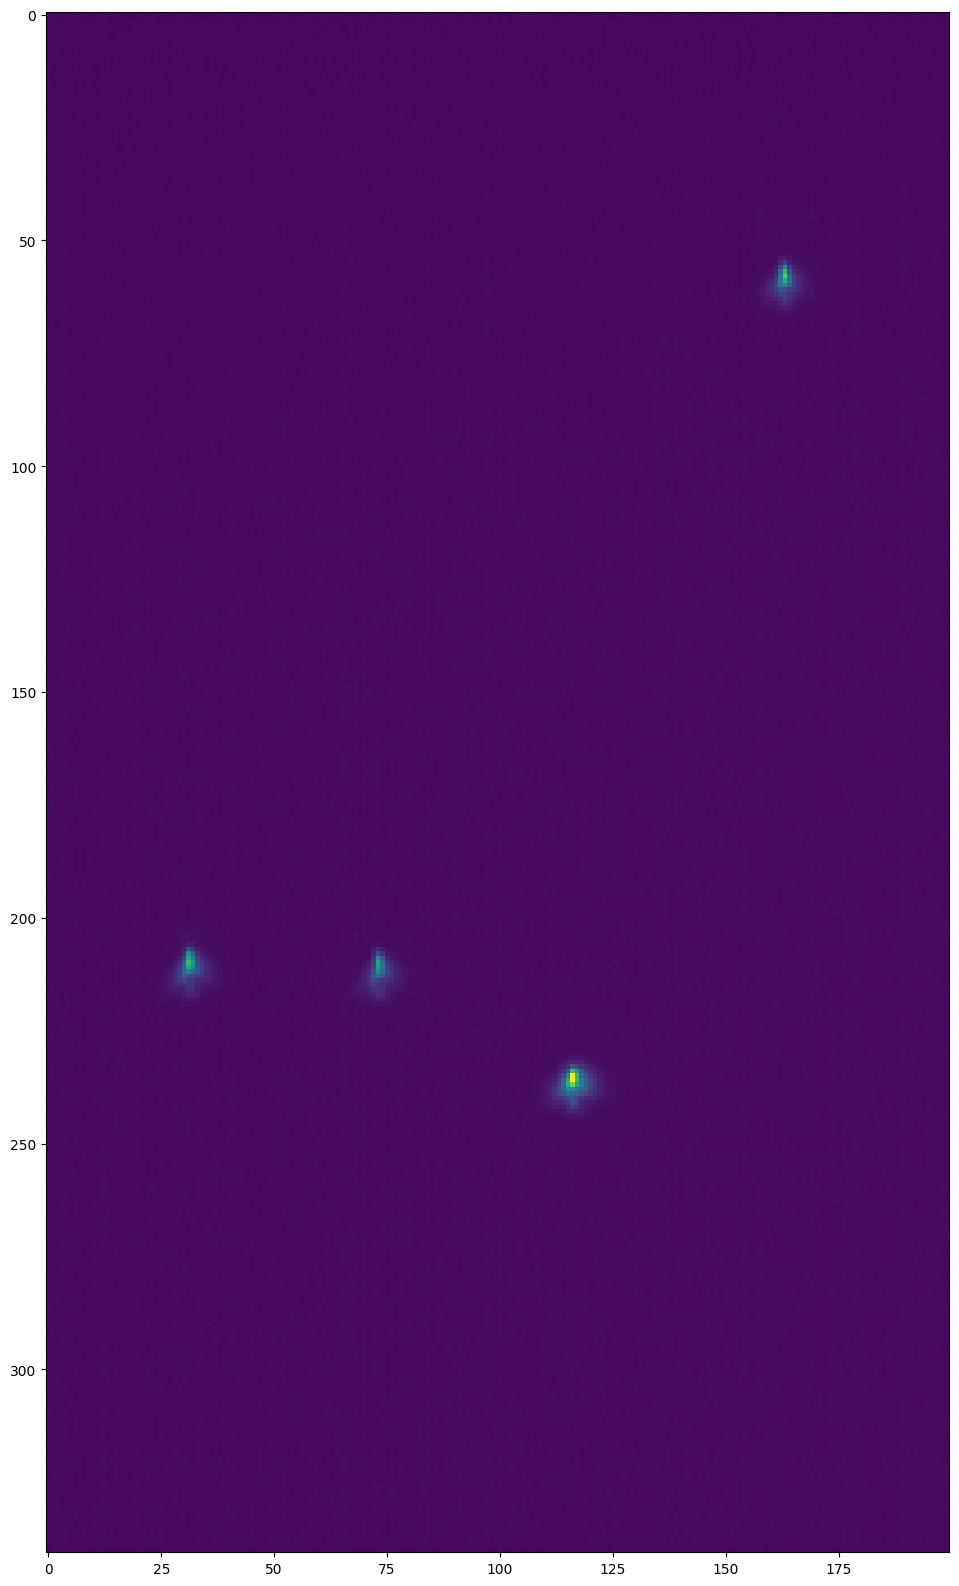

In [18]:
plt.figure(figsize=(20, 20))
plt.imshow(img_488.get()[1050:1250, :100, :].max(axis=1).T, vmax=3000)

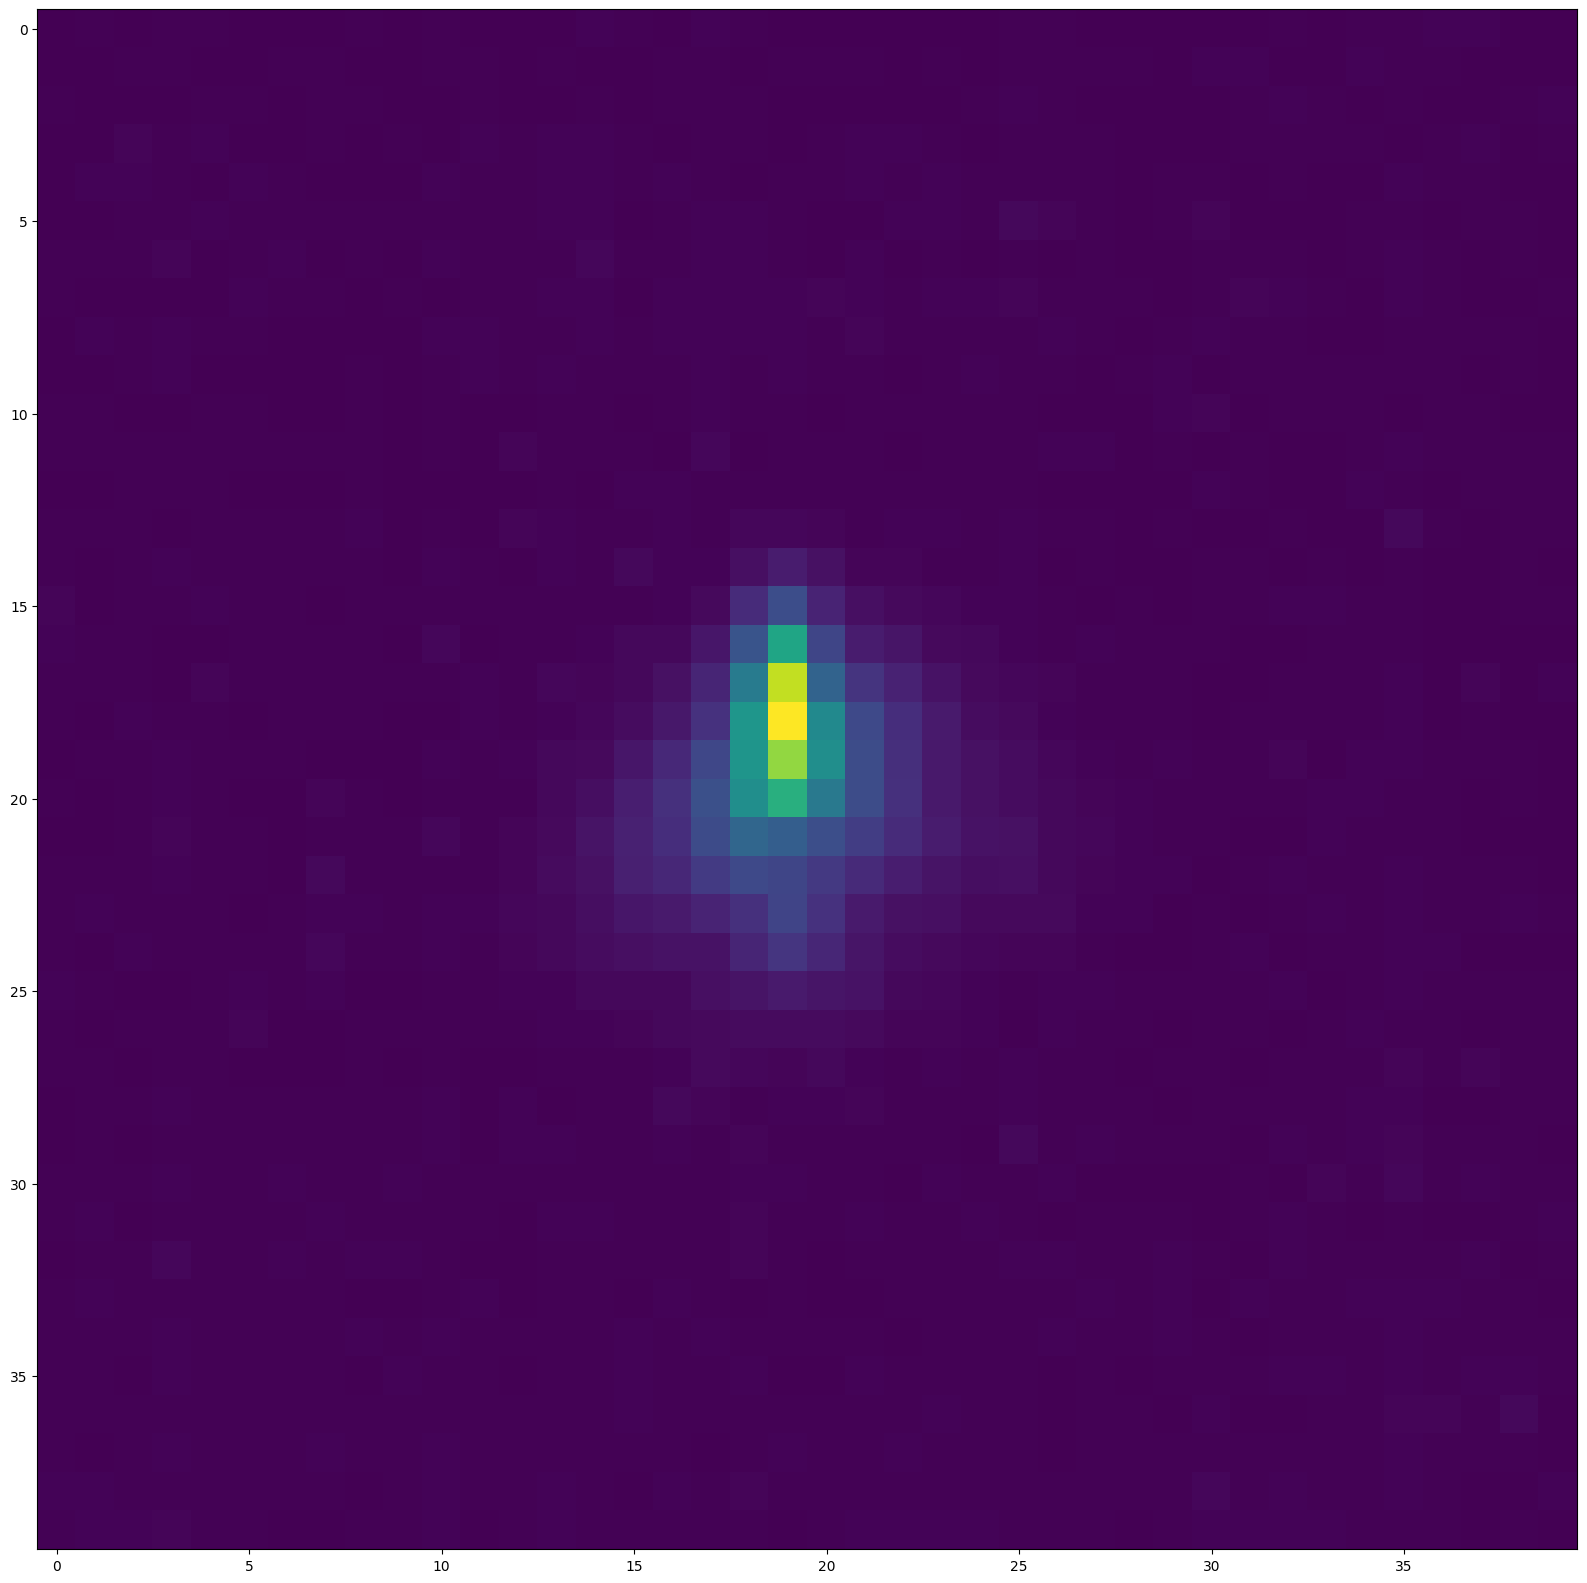

In [22]:
plt.figure(figsize=(20, 20))
plt.imshow(img_488.get()[1194:1234, :, 40:80].max(axis=1).T)

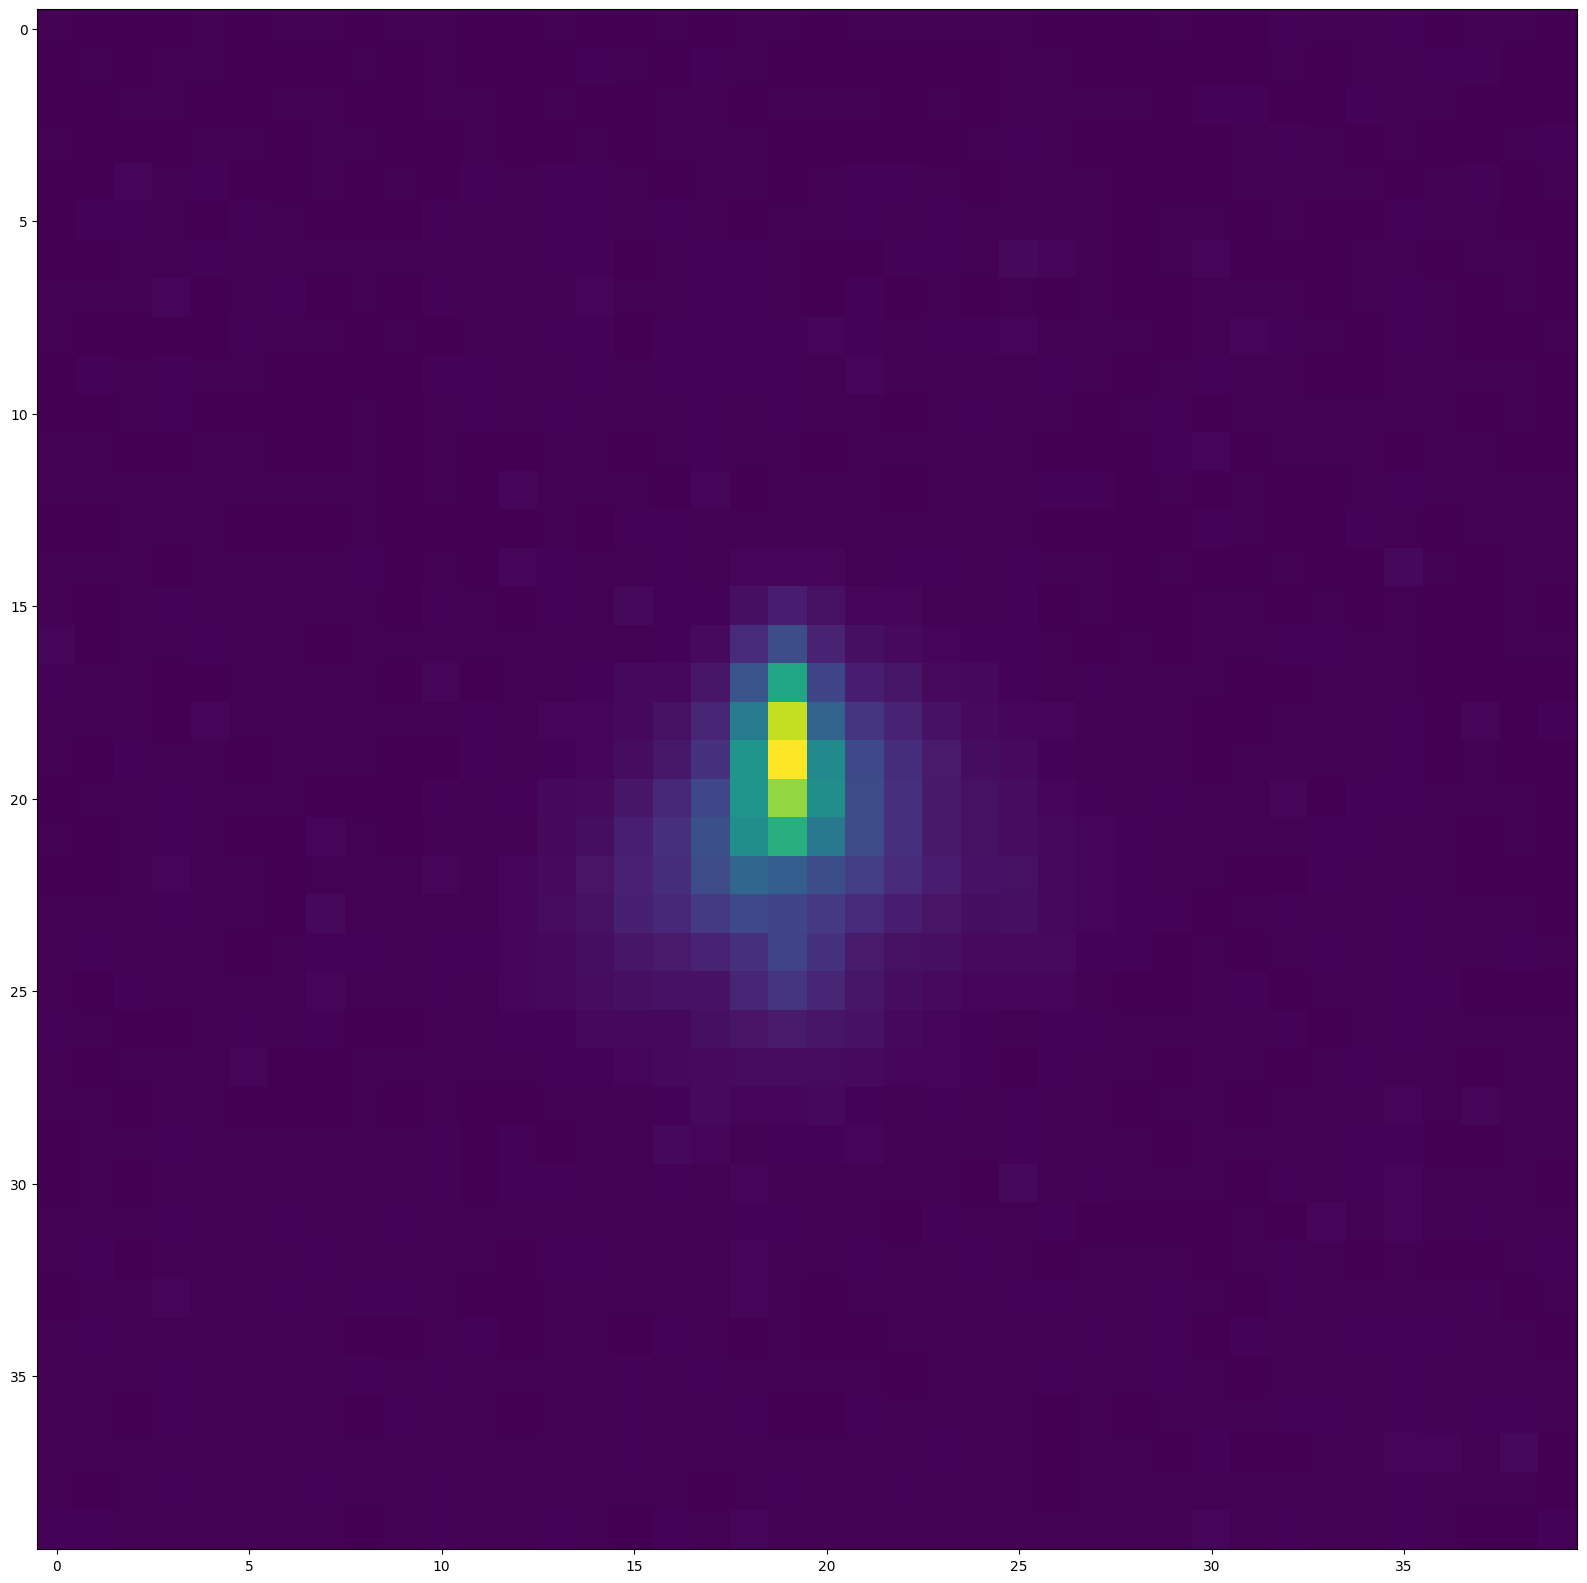

In [24]:
plt.figure(figsize=(20, 20))
plt.imshow(img_488.get()[1194:1234, :, 39:79].max(axis=1).T)

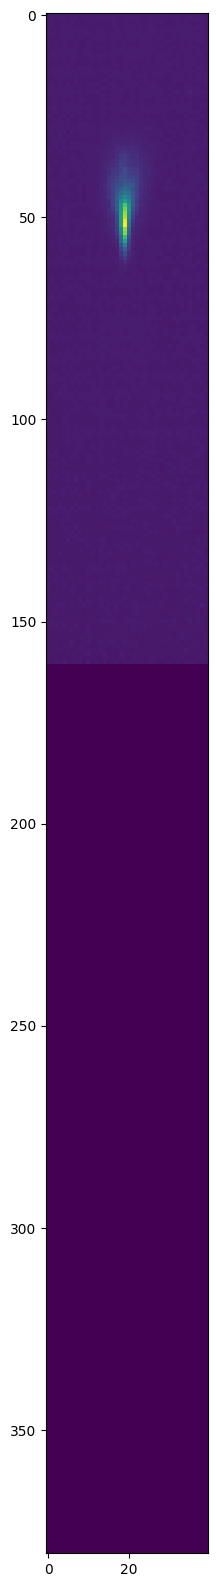

In [25]:
plt.figure(figsize=(20, 20))
plt.imshow(img_488.get()[1194:1234, :, 39:79].max(axis=2).T)

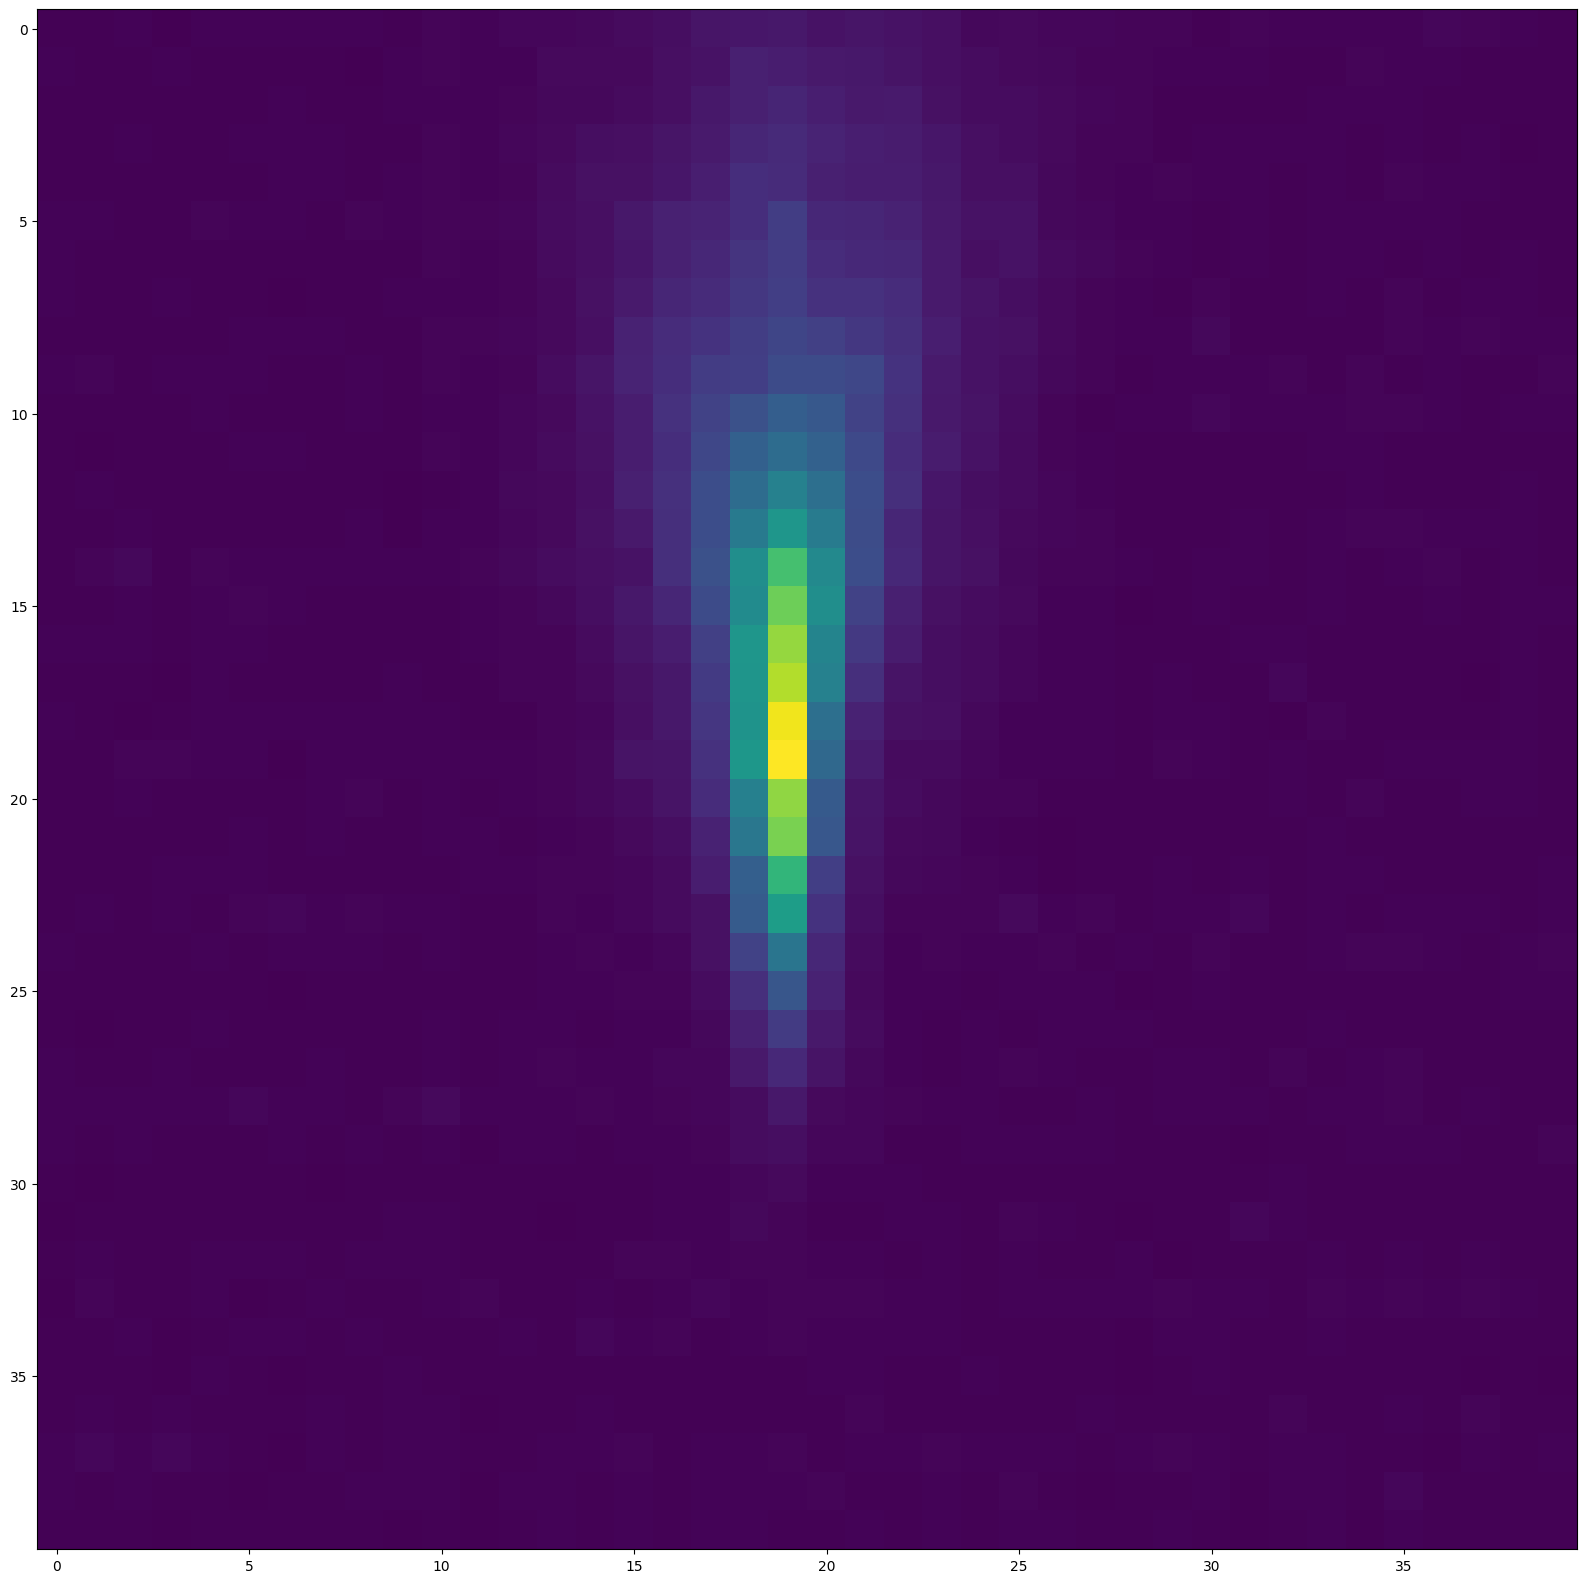

In [26]:
plt.figure(figsize=(20, 20))
plt.imshow(img_488.get()[1194:1234, 33:73, 39:79].max(axis=2).T)

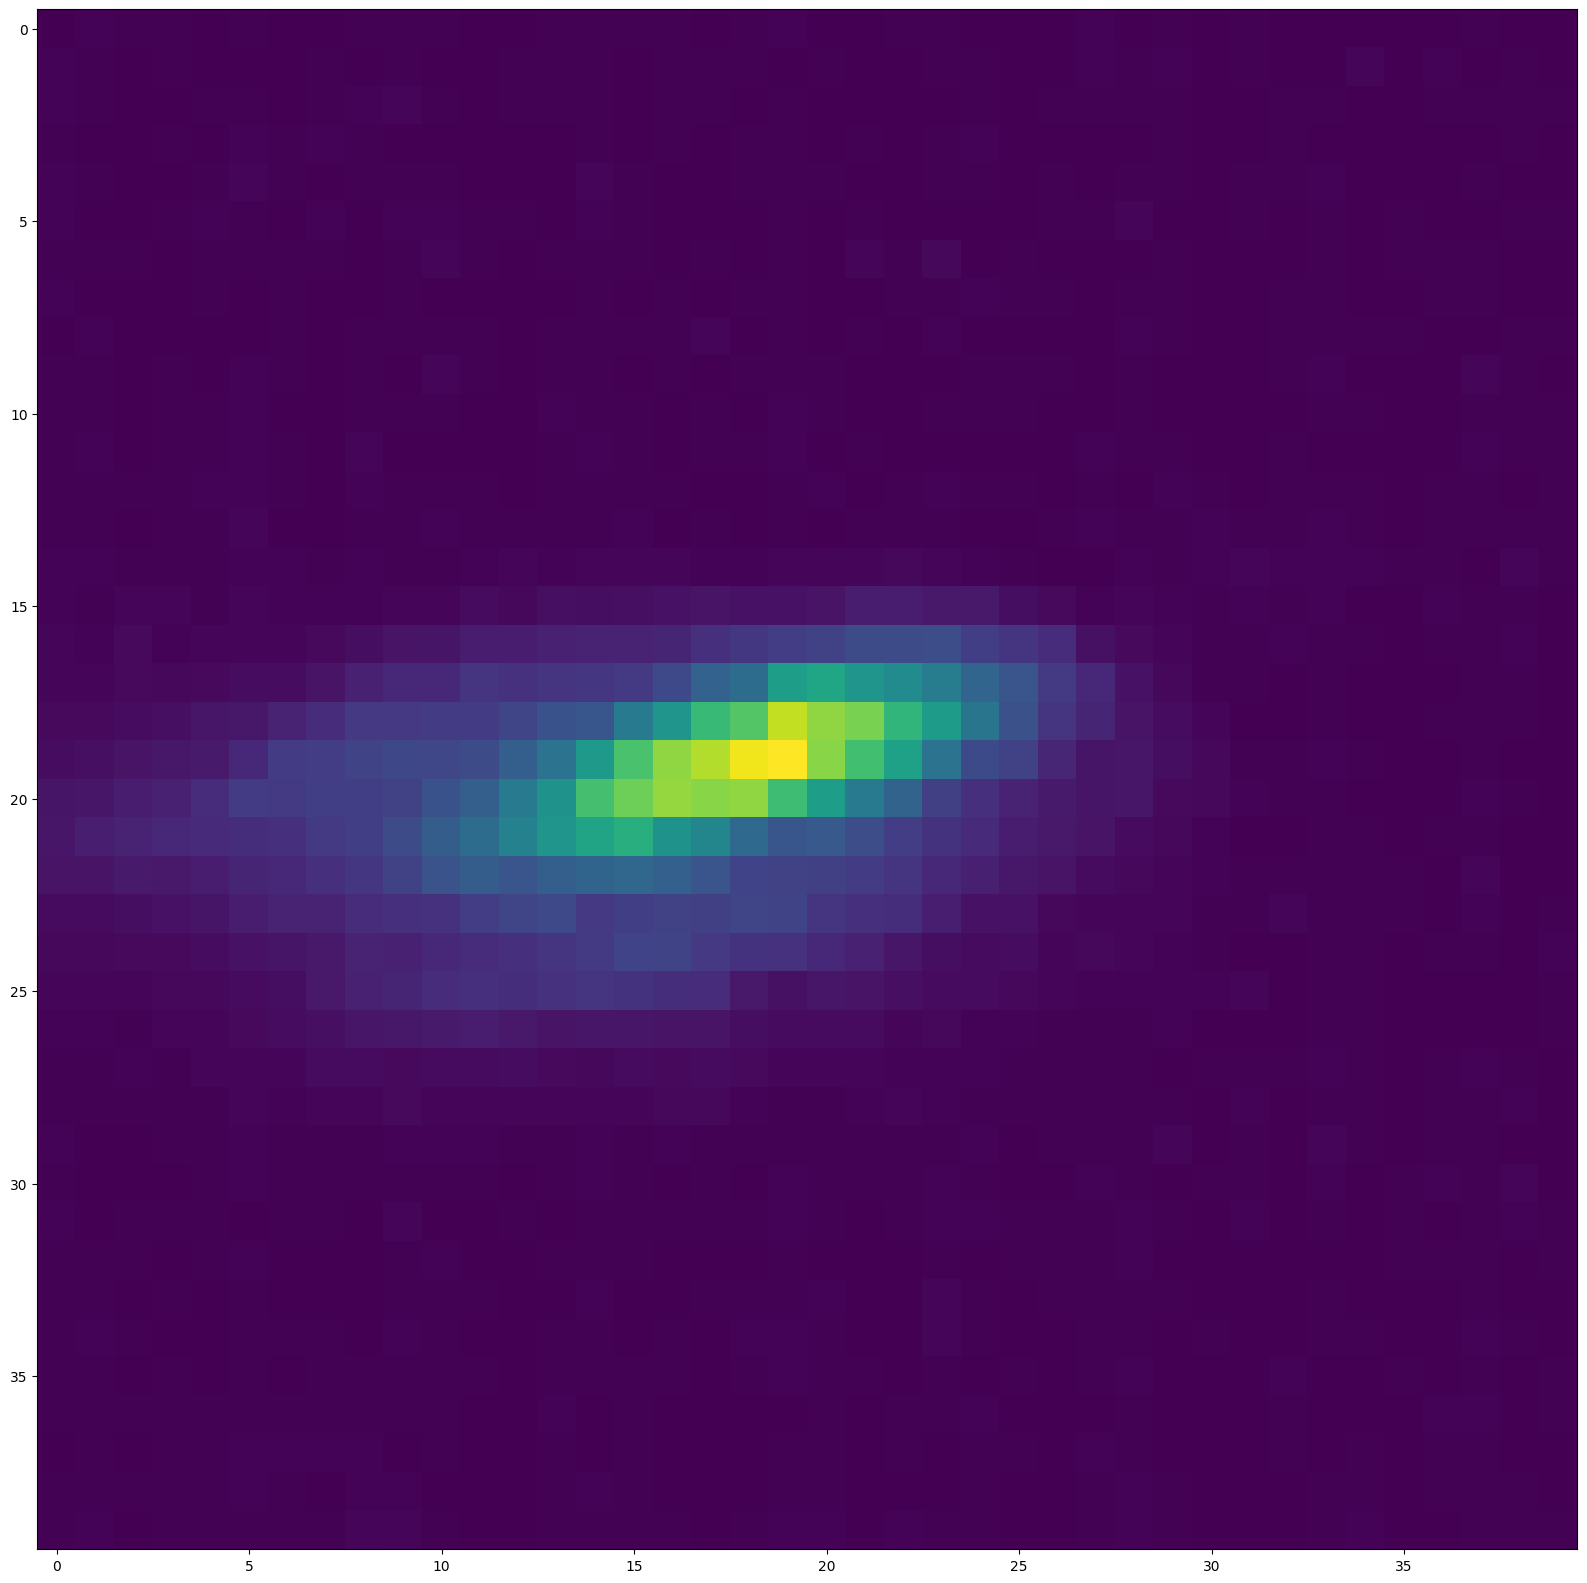

In [28]:
plt.figure(figsize=(20, 20))
plt.imshow(img_488.get()[1194:1234, 33:73, 39:79].max(axis=0).T)

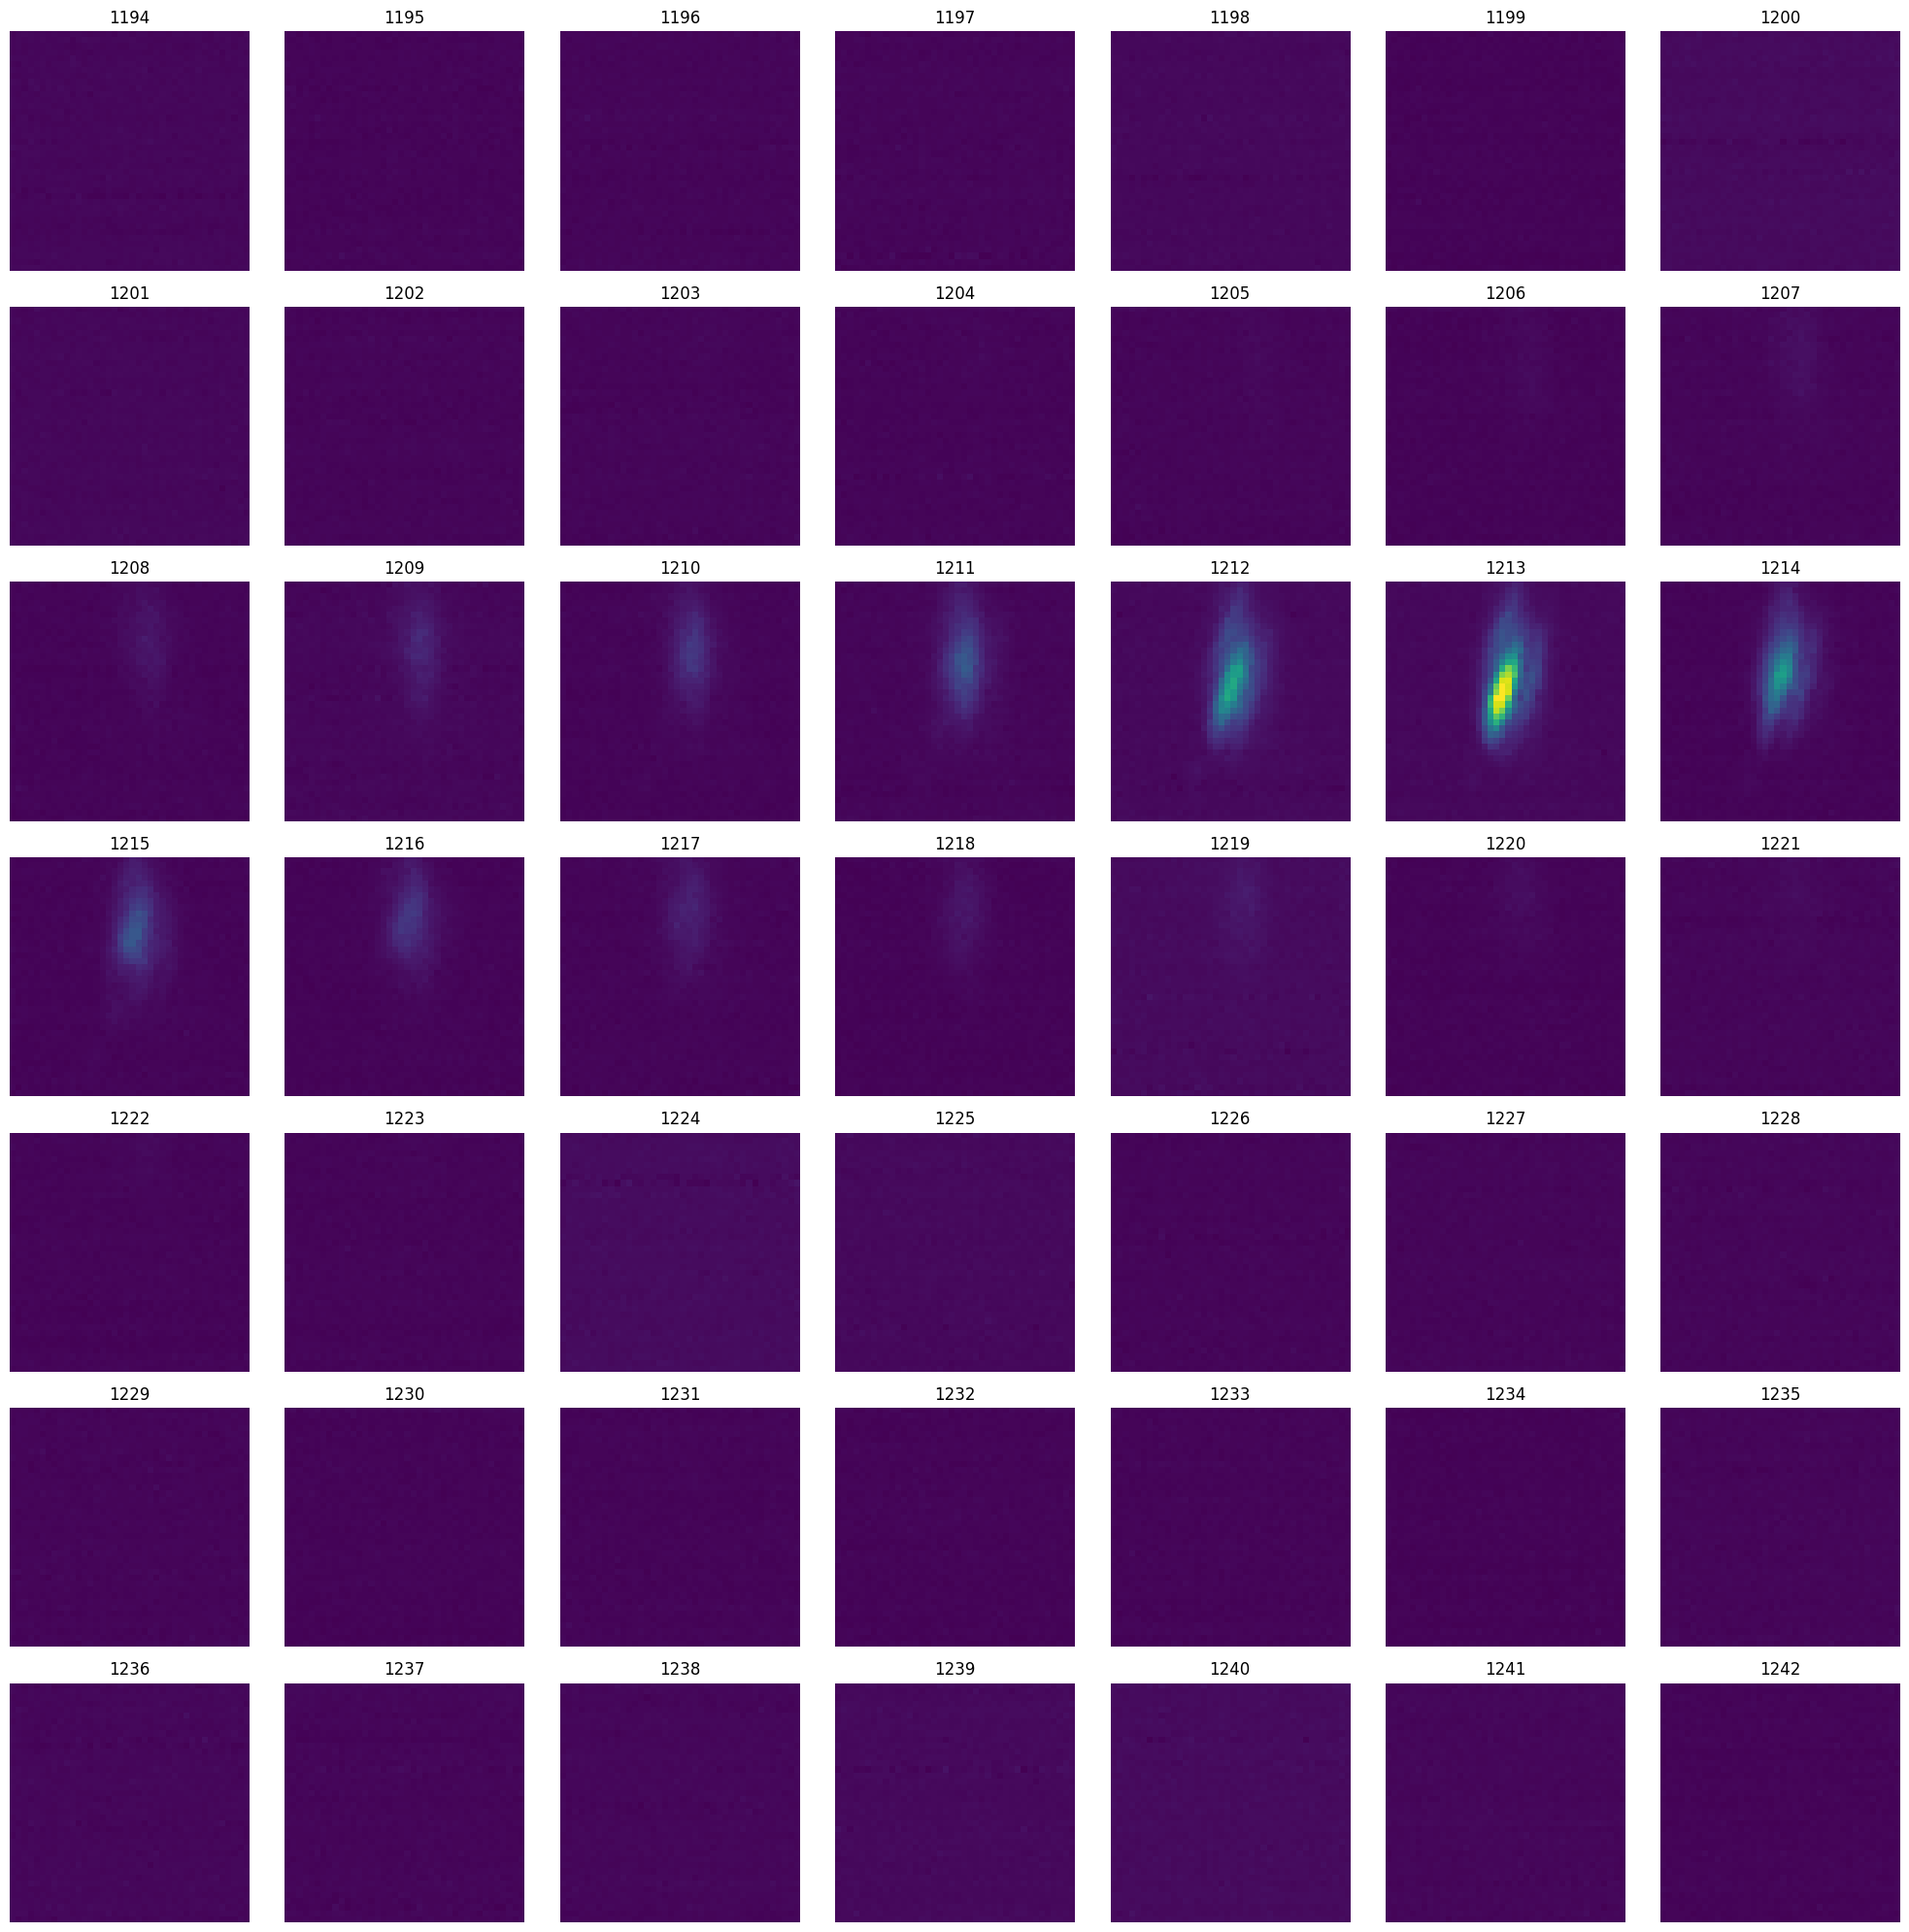

In [36]:
img = img_488.get()
fig, axes = plt.subplots(7, 7, figsize=(20, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(img[1194+i, 33:73, 39:79], vmax=2000)
    ax.axis('off')
    ax.set_title(1194+i)

plt.tight_layout()

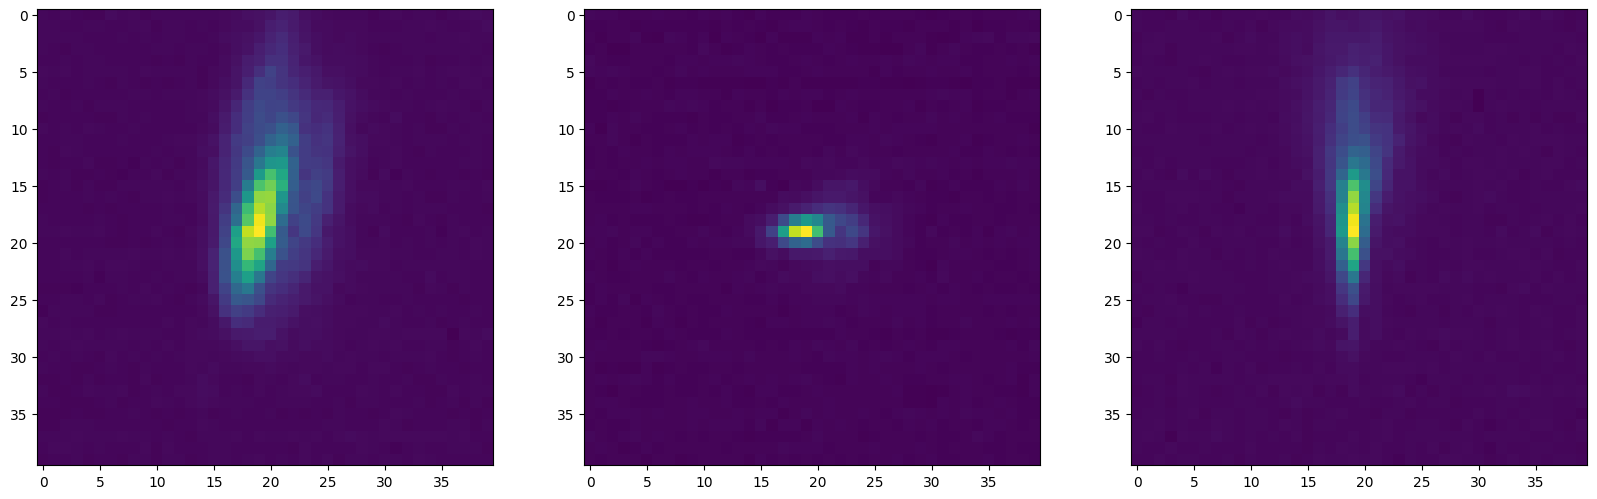

In [37]:
img = img_488.get()

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

axes[0].imshow(img[1213, 33:73, 39:79])
axes[1].imshow(img[1194:1234, 52, 39:79])
axes[2].imshow(img[1194:1234, 33:73, 58].T)

In [39]:
tifffile.imwrite(RESULT_PATH+'xy-z52.tif', img[1194:1234, 52, 39:79])
tifffile.imwrite(RESULT_PATH+'zy-x1213.tif', img[1213, 33:73, 39:79])
tifffile.imwrite(RESULT_PATH+'zx-y58.tif', img[1194:1234, 33:73, 58].T)